# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
from geopandas import GeoDataFrame
import shapely
from fiona.crs import from_epsg
import statsmodels.api as sm
import pysal as ps
import matplotlib.pylab as plt
from matplotlib import colors
import seaborn as sns

sns.set_style("white")

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:

shape_path = "Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [4]:

ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area = ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print ('total NYC land area: %s (mi^2)'%str(NYC_Area)[:5]) # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

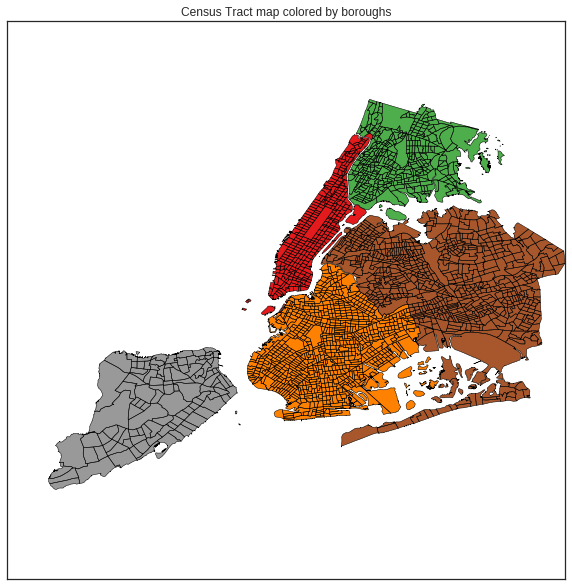

In [5]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

## Figure 1: Cencus tracts in Boroughs of NYC

### Map NYC Population density

#### Load Census Data for 2010

In [6]:
ct_data = DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index = ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [7]:
ct_shape_pop = ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


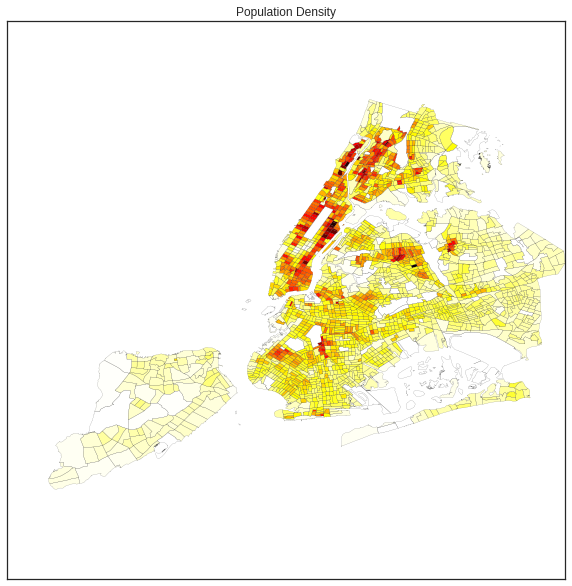

In [8]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

## Figure 2: Population density by census tracts in NYC.

## Explore CitiBike data

### Load CitiBike data

In [9]:
df_bike_monthly = DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


## Spilt the data into Summer and Winter 

This seasonal separation could be done by two ways
* spilt the 12 months into two categories with six months in each or
* split by actual summer and winter months which are 3 months into four seasons. 

I chose to spilt by actual summer and winter months. 
* Summer - June to September
* Winter - December to March

In [10]:
month = df_bike_monthly.index.month
df_bike_summer = df_bike_monthly[(month >= 6) & (month <= 9)]
df_bike_winter = df_bike_monthly[(month >= 12) | (month <= 3)]

### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


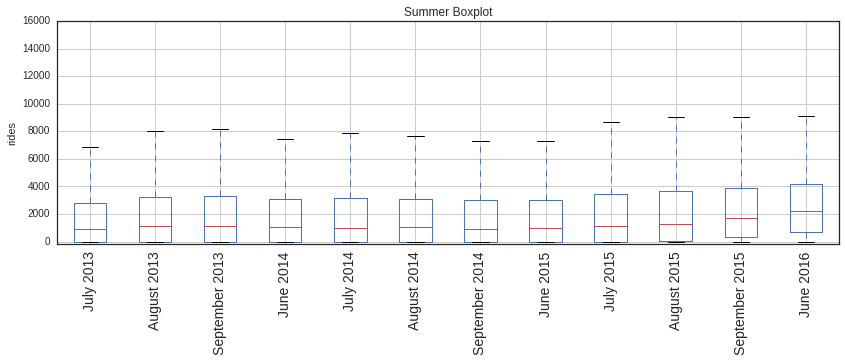

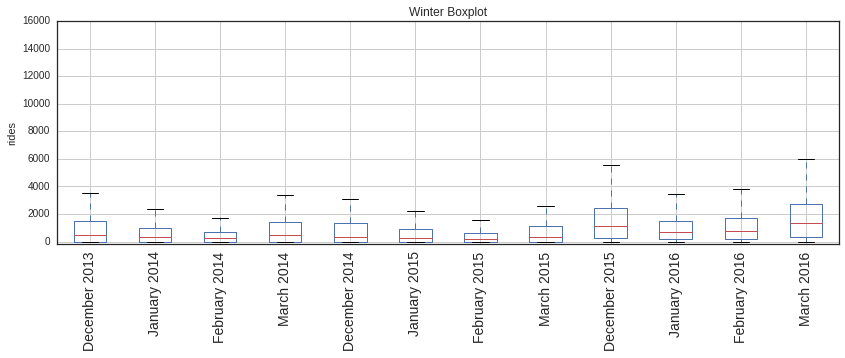

In [11]:
plt.rcParams['font.size']=14

f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_summer_ = df_bike_summer.copy()
df_bike_summer_.index = df_bike_summer_.index.strftime("%B %Y")
df_bike_summer_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])
ax.set_title("Summer Boxplot")
ax.set_ylabel("rides")

f1, ax1 = plt.subplots(figsize=(14,4))
df_bike_winter_ = df_bike_winter.copy()
df_bike_winter_.index = df_bike_winter_.index.strftime("%B %Y")
df_bike_winter_.T.boxplot(figsize=(15,7), ax=ax1, rot=90)
ax1.set_ylim([-200,16000])  
ax1.set_title("Winter Boxplot")
ax1.set_ylabel("rides")

## Figure 3: Box plots of summer and winter months
There is a clear decline in winter ridership. 

#### Seasonal Decomposition

/opt/rh/anaconda/root/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


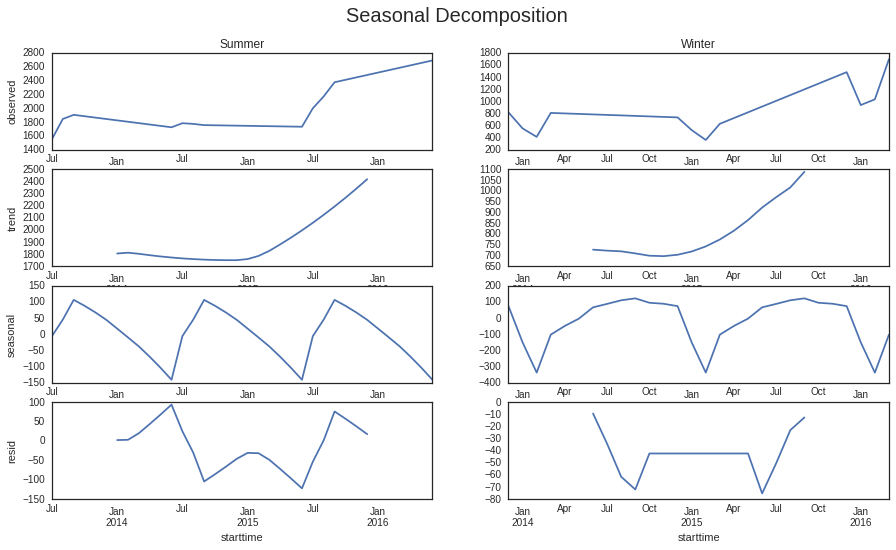

In [12]:
#Create a monthly time series of bike ride (Average of all citibike stations)
df_summer_new = df_bike_summer.mean(1).resample('M').mean()
df_summer_new.interpolate(inplace=True)

df_winter_new = df_bike_winter.mean(1).resample('M').mean()
df_winter_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res_summer = sm.tsa.seasonal_decompose(df_summer_new.dropna())
res_winter = sm.tsa.seasonal_decompose(df_winter_new.dropna())

labels = ['observed', 'trend', 'seasonal', 'resid']

fig = plt.figure(figsize=(15,8))
plt.suptitle("Seasonal Decomposition", fontsize=20)
for i in range(8):
    ax = fig.add_subplot(4, 2, i+1)
    if i%2 == 0:
        eval('res_summer.' + str(labels[i/2])).plot(ax=ax, legend=False)
        ax.set_ylabel(labels[i/2])
    else:
        eval('res_winter.' + str(labels[i/2])).plot(ax=ax, legend=False)
    if i == 0:
        ax.set_title('Summer')
    if i == 1:
        ax.set_title('Winter')

## Figure 4: Seasonal Decomposition of Citibike ridership.
The difference between summer and winter patterns is clearly seen but still both the seasons show an increasing trends. The rate of increase is higher for summer than winter.

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [13]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [14]:
# combine lat and lon to one column
station_id['lonlat'] = zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [15]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [16]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [17]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAveSummer'] = df_bike_summer.sum() / 3
station_id['MonthlyAveWinter'] = df_bike_winter.sum() / 3

In [18]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAveSummer,MonthlyAveWinter
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,10232.000000,4387.666667
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,15322.000000,5371.000000
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,39612.333333,17646.666667
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,14931.333333,6513.666667
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,27583.000000,10439.666667


### Add the monthly average rides to the CT shapefile 

In [19]:
# use the 
temp=station_id[['MonthlyAveSummer', 'MonthlyAveWinter']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAve=ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


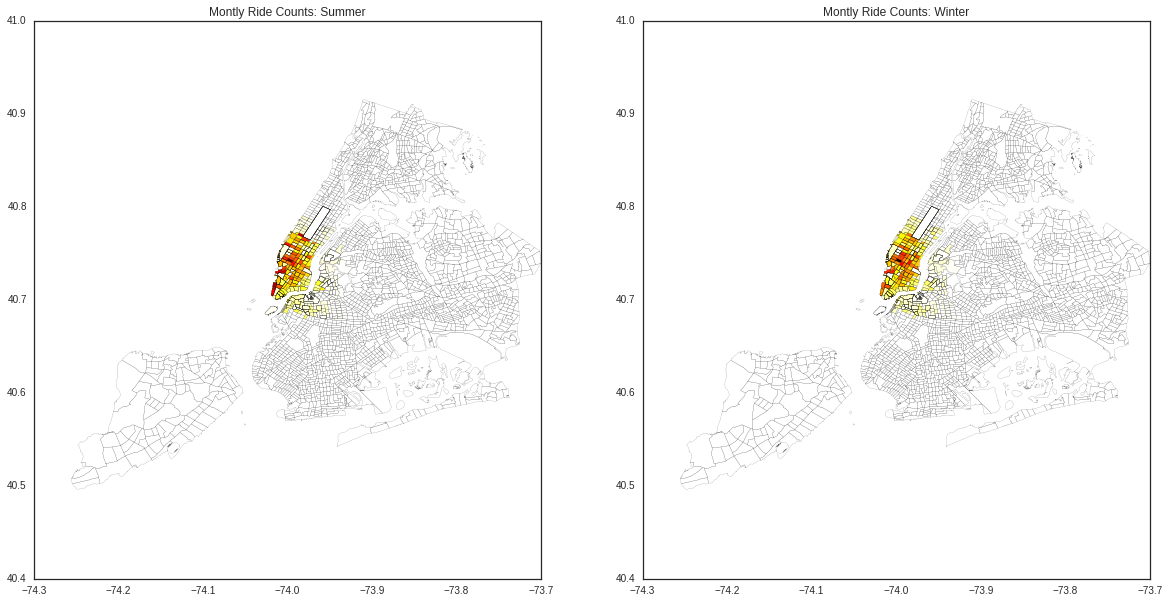

In [20]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ct_shape_MonthlyAve.plot(column='MonthlyAveSummer', colormap='hot_r', alpha=1, linewidth=0.1,ax=ax1)
ct_shape_MonthlyAve.plot(column='MonthlyAveWinter', colormap='hot_r', alpha=1, linewidth=0.1,ax=ax2)
ax1.set_title("Montly Ride Counts: Summer")
ax2.set_title("Montly Ride Counts: Winter")

## Figure 5: Monthly Ridership volumes for summer and winter months. 
The citibike data is for Manhanttan and some areas in Brooklyn, so these plots show ridership only for those areas. 
Lets zoom in to understand the patterns. 

### Removing the CTs that are out of zoom boundries

In [21]:
ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [22]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.MonthlyAveSummer)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

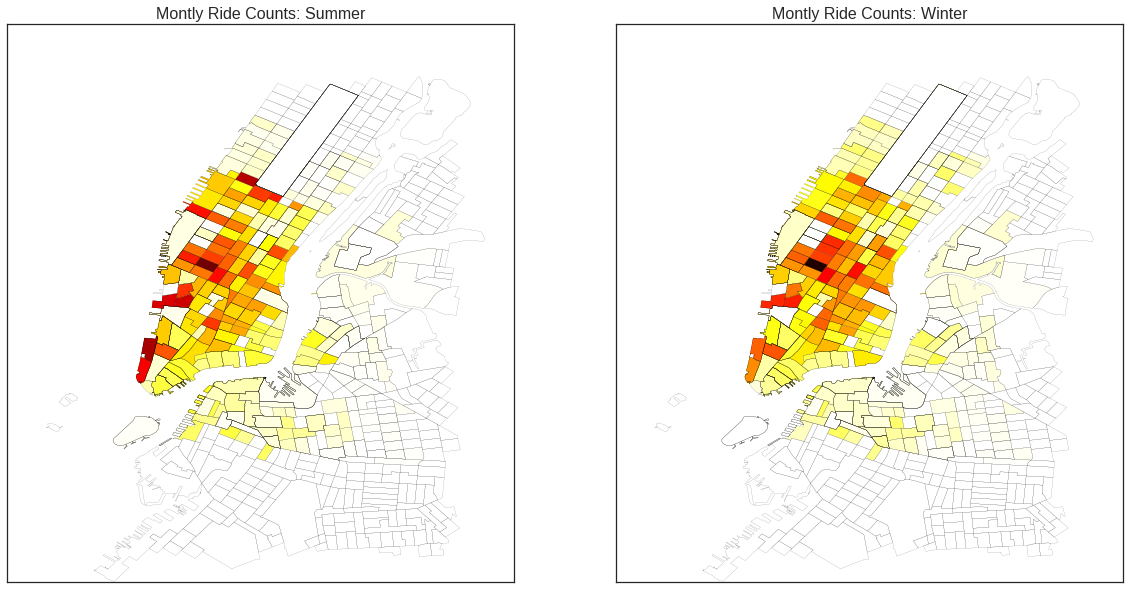

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAveSummer', colormap='hot_r', alpha=1, linewidth=0.1,ax=ax1)
ax1.set_title("Montly Ride Counts: Summer", fontsize=16)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAveWinter', colormap='hot_r', alpha=1, linewidth=0.1,ax=ax2)
ax2.set_title("Montly Ride Counts: Winter", fontsize=16)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

## Figure 6: Zoomed in monthly ridership for summer and winter months. 
The dark spots in summer months show high ridership for summer months.

### Export Shapefile CTs in the CitiBike Zone

In [24]:
path='Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [25]:
qW_CT=ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [26]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [27]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [28]:
Wmatrix, ids = qW_CT.full()

In [29]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [30]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neighbors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [31]:
MonthlyRideSummer = ct_shape_MonthlyAve_Zoom.MonthlyAveSummer
MonthlyRideSummerLag = ps.lag_spatial(qW_CT, MonthlyRideSummer)

MonthlyRideWinter = ct_shape_MonthlyAve_Zoom.MonthlyAveWinter
MonthlyRideWinterLag = ps.lag_spatial(qW_CT, MonthlyRideWinter)

#### Create Quantiles for maping

In [32]:
MonthlyRideLagSummerQ10 = ps.Quantiles(MonthlyRideSummerLag, k=10)
MonthlyRideLagWinterQ10 = ps.Quantiles(MonthlyRideWinterLag, k=10)
print "Summer deciles", MonthlyRideLagSummerQ10
print ""
print "Winter deciles", MonthlyRideLagWinterQ10

Summer deciles                    Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=    29.333                 2
   29.333 < x[i] <=   503.875                78
  503.875 < x[i] <=  1025.000                80
 1025.000 < x[i] <=  2517.133                81
 2517.133 < x[i] <=  3875.952                78
 3875.952 < x[i] <=  8564.601                79
 8564.601 < x[i] <= 12465.071                80
12465.071 < x[i] <= 14399.552                79
14399.552 < x[i] <= 22012.167                80

Winter deciles                   Quantiles                  
 
 Lower              Upper               Count
           x[i] <=    0.000               159
   0.000 < x[i] <=   18.381                 2
  18.381 < x[i] <=  300.757                78
 300.757 < x[i] <=  721.778                80
 721.778 < x[i] <= 1150.971                79
1150.971 < x[i] <= 1671.361                80
1671.361 < x[i] <= 37

#### Map the monthly rides lag

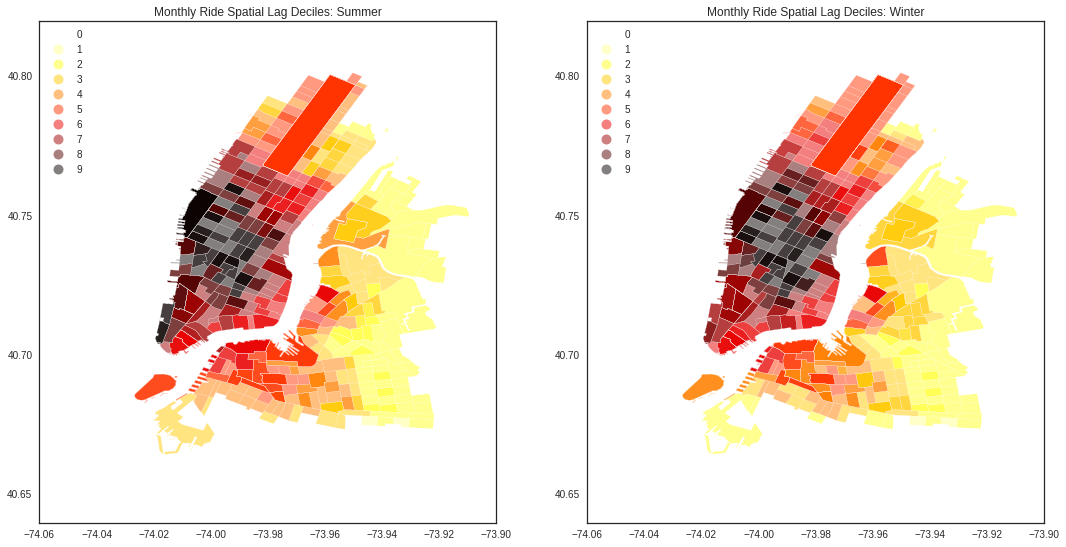

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagSummerQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)
ax1.set_title("Monthly Ride Spatial Lag Deciles: Summer")
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagWinterQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)
ax2.set_title("Monthly Ride Spatial Lag Deciles: Winter")

## Figure 7: Decline of average summer and winter months. 
One most obvious part is, there are some census tracts appear as decile 1 in summer but don't appear at winter (decile 0) --> the southern part of Brooklyn.
It can be also be observed that Governors Island has 5-6 lag, but as its an island its strange for citibike rides to and fro from Governors island. This is due to the formation of the census tract covering the piers along with the island. 

## Global  Spatial Autocorrelation

In [34]:
bSummer, aSummer = np.polyfit(MonthlyRideSummer, MonthlyRideSummerLag, 1)
bWinter, aWinter = np.polyfit(MonthlyRideWinter, MonthlyRideWinterLag, 1)
print "polyfit summer:", bSummer, aSummer
print "polyfit winter:", bWinter, aWinter 

polyfit summer: 0.643893143126 1894.31035958
polyfit winter: 0.661894622507 777.272547092


### Moran Scatterplot

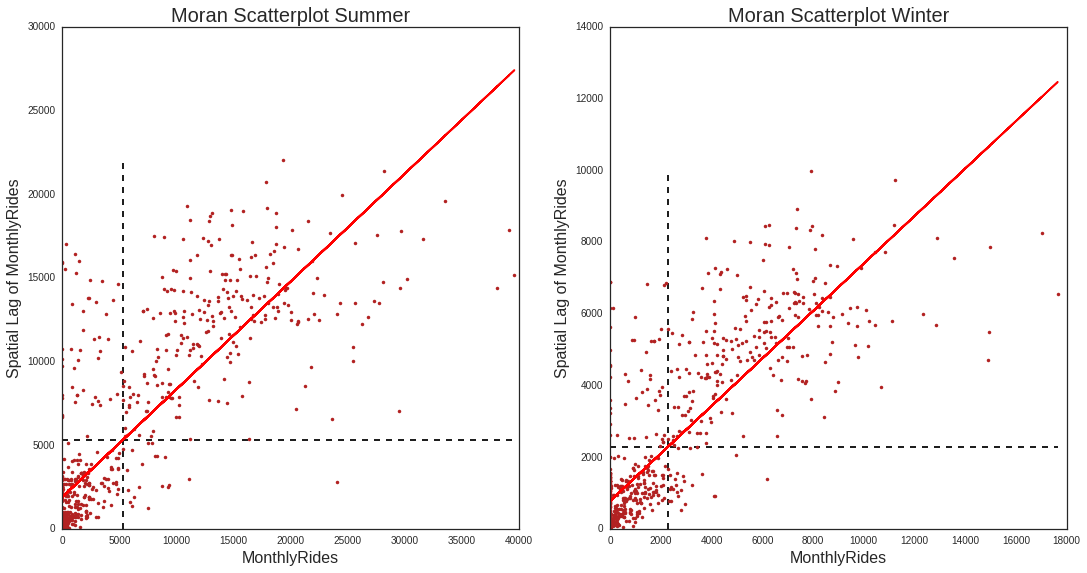

In [35]:
f, ax = plt.subplots(1,2, figsize=(18, 9))
season = ['Summer', 'Winter']

for i in range(2):
    df1 = eval('MonthlyRide' + season[i])
    df2 = eval('MonthlyRide' + season[i] + 'Lag')
    a = eval('a' + season[i])
    b = eval('b' + season[i])
               
    ax[i].plot(df1, df2, '.', color='firebrick')
    # dashed vert at mean of the last year's PCI
    ax[i].vlines(df1.mean(), df1.min(), df2.max(), linestyle='--')
    # dashed horizontal at mean of lagged PCI
    ax[i].hlines(df2.mean(), df1.min(), df1.max(), linestyle='--')

    # red line of best fit using global I as slope
    ax[i].plot(df1, a + b*df1, 'r')
    ax[i].set_title('Moran Scatterplot ' + str(season[i]), fontsize=20)
    ax[i].set_ylabel('Spatial Lag of MonthlyRides', fontsize=16)
    ax[i].set_xlabel('MonthlyRides', fontsize=16)

## Figure 8: Moran Scatterplots for Summer and Winter. 
The spatial lag plots for summer months has riders 20000 - 60000 as compared to winter riders ranging from 10000 - 30000 which is almost half the summer months. 

### Moran's I

In [36]:
I_MonthlyRideSummer = ps.Moran(MonthlyRideSummer, qW_CT)
I_MonthlyRideWinter = ps.Moran(MonthlyRideWinter, qW_CT)

In [37]:
print "Summer", I_MonthlyRideSummer.I, I_MonthlyRideSummer.p_sim
print "Winter", I_MonthlyRideWinter.I, I_MonthlyRideWinter.p_sim

Summer 0.644069499068 0.001
Winter 0.662044196711 0.001


#### Thus, the $I$ statistic is $0.644$ for Summer, and has a very small $p$ value. 
#### Also the $I$ statistic is $0.662$ for winter, and has a very small $p$ value. 

In [38]:
print "Summer", I_MonthlyRideSummer.sim[0:10]
print "Winter", I_MonthlyRideWinter.sim[0:10]

Summer [-0.00014336 -0.00432969  0.00135926 -0.0266431  -0.01628928 -0.00634691
  0.0163447   0.01220354  0.01292185 -0.00273688]
Winter [-0.01852953 -0.0034894  -0.00039617  0.00309375 -0.004146    0.00655751
  0.00286164 -0.01481556  0.00471548  0.00424456]


### KDEplot of all of the simulated points
the vertical line shows the observed value

In [39]:

plt.rcParams['figure.figsize']=(14,3)

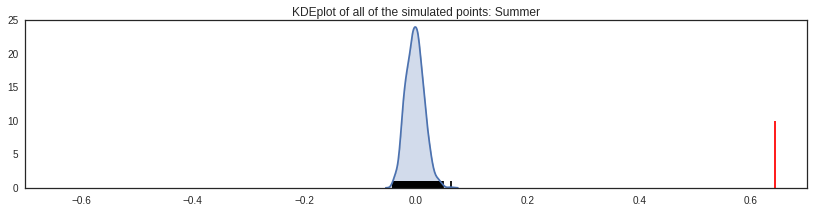

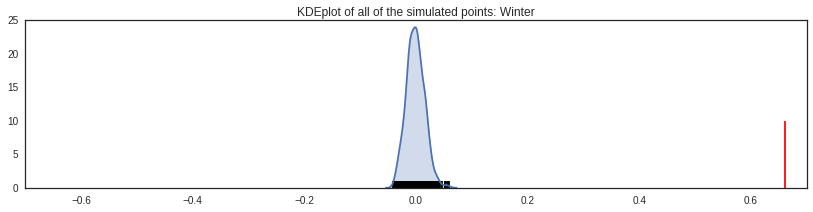

In [40]:
for i in range(2):
    df = eval('I_MonthlyRide' + season[i])
    fig = plt.figure()
    sns.kdeplot(df.sim, shade=True)
    plt.vlines(df.sim, 0, 1)
    plt.vlines(df.I, 0, 10, 'r')
    plt.title('KDEplot of all of the simulated points: ' + str(season[i]))
    plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

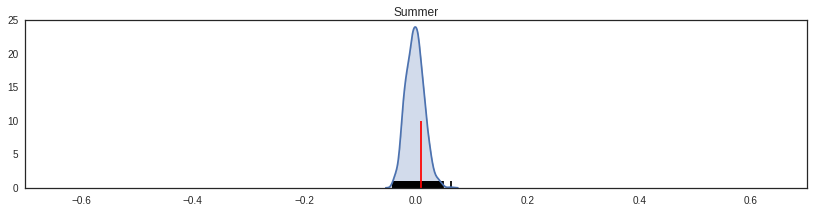

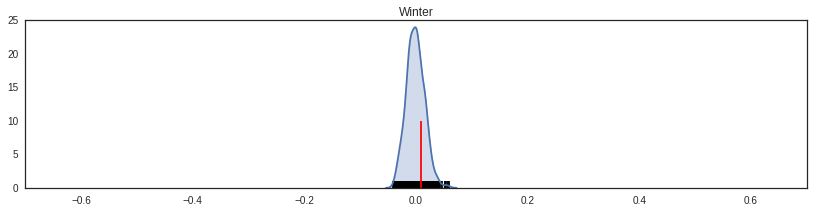

In [41]:
for i in range(2):
    df = eval('I_MonthlyRide' + season[i])
    fig = plt.figure()
    sns.kdeplot(df.sim, shade=True)
    plt.vlines(df.sim, 0, 1)
    plt.vlines(df.EI+.01, 0, 10, 'r')
    plt.title(str(season[i]))
    plt.xlim([-.70, .70])

## Local  Spatial Autocorrelation

In [42]:
LMo_MonthlyRideSummer = ps.Moran_Local(MonthlyRideSummer, qW_CT,permutations=999)
LMo_MonthlyRideWinter = ps.Moran_Local(MonthlyRideWinter, qW_CT,permutations=999)

In [43]:
print "Summer", LMo_MonthlyRideSummer.Is[0:5], LMo_MonthlyRideSummer.p_sim[0:5]
print "Winter", LMo_MonthlyRideWinter.Is[0:5], LMo_MonthlyRideWinter.p_sim[0:5]

Summer [-0.         -0.23689404  0.01179723  0.00235718  0.0247348 ] [ 0.001  0.184  0.382  0.332  0.387]
Winter [-0.         -0.3153042  -0.00110645 -0.00100209 -0.06082761] [ 0.001  0.129  0.455  0.466  0.444]


### LISA (Local Indicators of Spatial Autocorrelation)

In [44]:
def getLisa(MonthlyRide, LMo_MonthlyRide, MonthlyRideLag):
    ''' This function is to get significant values of LISA'''
    sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .001]
    W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
    insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .001]
    W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .001]
    return sigs, W_sigs, insigs, W_insigs

### Plot Signficant LISA

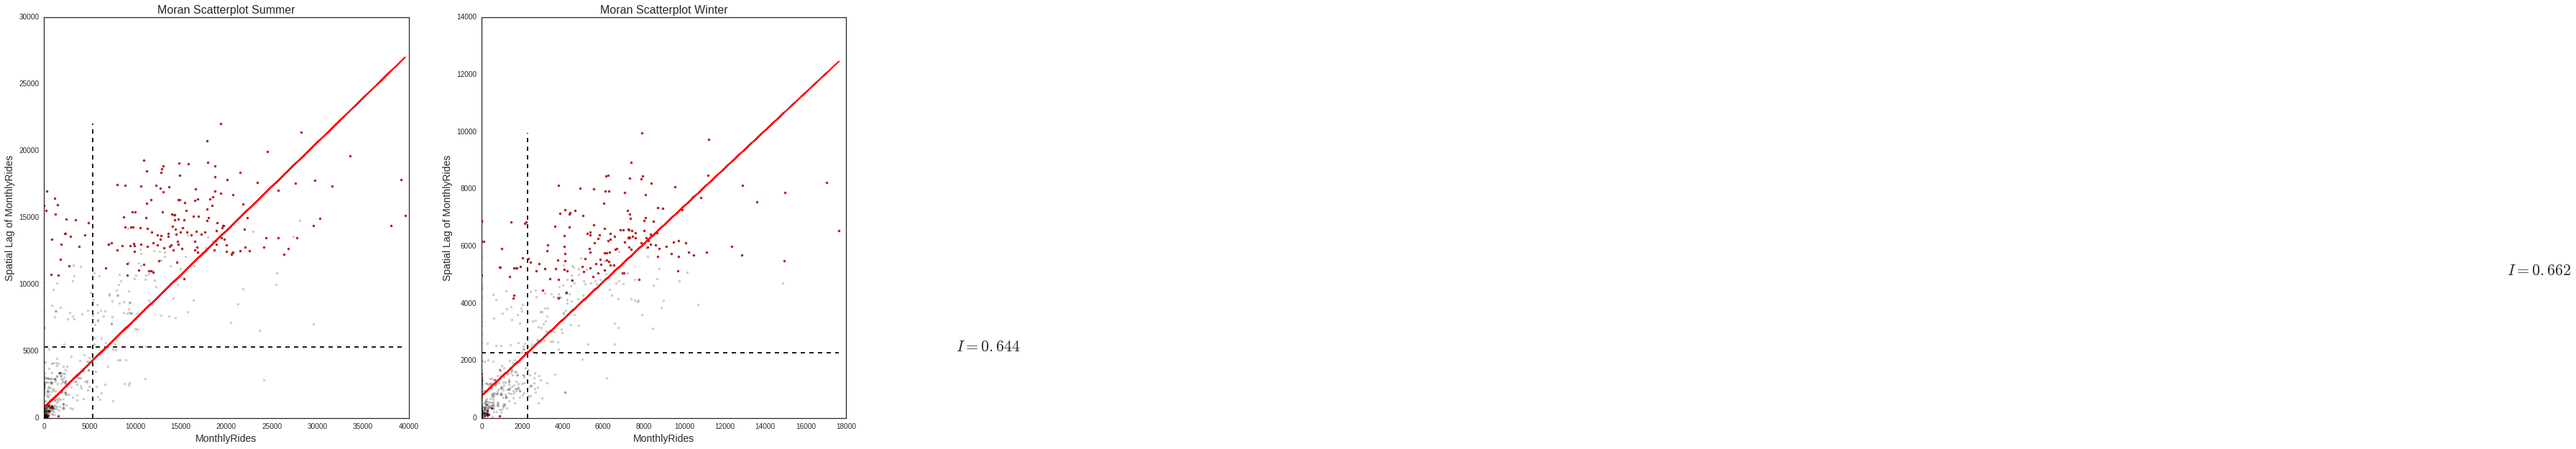

In [45]:
sns.set_style("white")
f, ax = plt.subplots(1, 2, figsize=(20, 10))

for i in range(2):
    MonthlyRide = eval('MonthlyRide' + season[i])
    LMo_MonthlyRide = eval('LMo_MonthlyRide' + season[i])
    MonthlyRideLag = eval('MonthlyRide' + season[i] + 'Lag') 
    I_MonthlyRide = eval('I_MonthlyRide' + season[i])
    sigs, W_sigs, insigs, W_insigs = getLisa(MonthlyRide, LMo_MonthlyRide, MonthlyRideLag)
    
    ax[i].plot(sigs, W_sigs, '.', color='firebrick')
    ax[i].plot(insigs, W_insigs, '.k', alpha=.2)
    ax[i].text(s='$I = %.3f$' % I_MonthlyRide.I, x=100000, y=5000, fontsize=22)

     # dashed vert at mean of the last year's PCI
    ax[i].vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
     # dashed horizontal at mean of lagged PCI
    ax[i].hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

    # red line of best fit using global I as slope
    ax[i].plot(MonthlyRide, a + b*MonthlyRide, 'r')
    ax[i].set_title('Moran Scatterplot ' + str(season[i]), fontsize=16)
    ax[i].set_ylabel('Spatial Lag of MonthlyRides', fontsize=14)
    ax[i].set_xlabel('MonthlyRides',fontsize=14)

## Figure 9: Monthly Scatter plots for Summer and Winter months

### Hot and Cold spots 

In [46]:
def getSpots(LMo_MonthlyRide, season):
    ''' A function to get the number of coldspots and hotspots'''
    sig = LMo_MonthlyRide.p_sim < 0.01
    hotspots = LMo_MonthlyRide.q==1 * sig
    coldspots = LMo_MonthlyRide.q==3 * sig
    print "Number of Hotspots", season, hotspots.sum()
    print "Number of Coldspots", season, coldspots.sum()
    return hotspots, coldspots

hotspotsSummer, coldspotsSummer = getSpots(LMo_MonthlyRideSummer, season[0])
hotspotsWinter, coldspotsWinter = getSpots(LMo_MonthlyRideWinter, season[1])

Number of Hotspots Summer 189
Number of Coldspots Summer 236
Number of Hotspots Winter 198
Number of Coldspots Winter 209


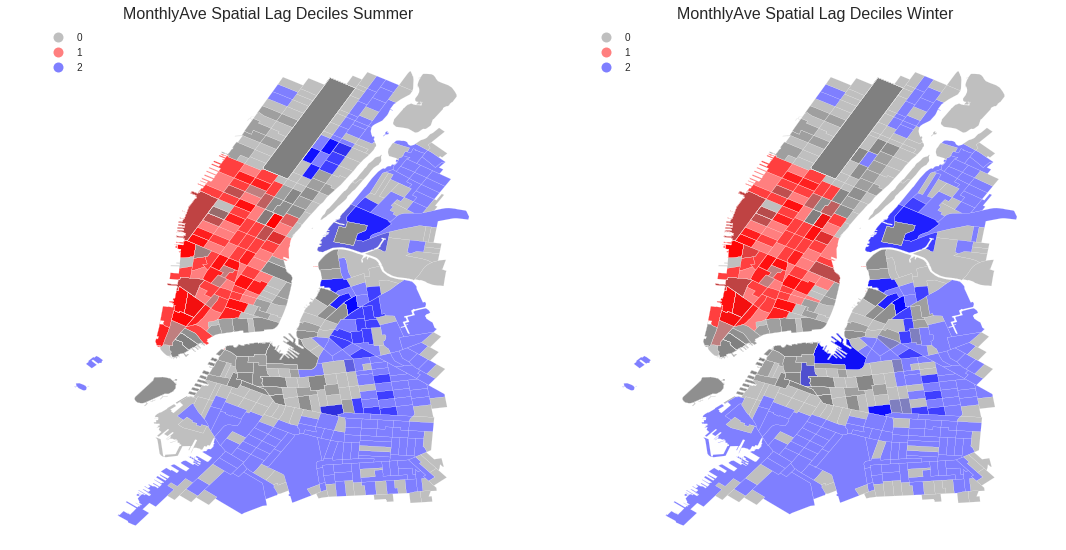

In [47]:
f, ax = plt.subplots(1, 2, figsize=(18, 9))

for i in range(2):
    hotspots = eval('hotspots' + season[i])
    coldspots = eval('coldspots' + season[i])
    
    hcmap = colors.ListedColormap(['grey','red','blue'])
    hotcold = hotspots*1 + coldspots*2

    ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
            k=10, cmap=hcmap, linewidth=0.1, ax=ax[i], 
            edgecolor='white', legend=True)
    ax[i].set_axis_off()
    ax[i].set_title("MonthlyAve Spatial Lag Deciles " + str(season[i]), fontsize=16)

## Figure 10: Hot and cold spots for summer and winter months.
Summer has 190 and 242 hotspots and coldspots respectively, while winter has 197 and 208 hotspots and coldspots. Winter has slighlty more spots but we can not barely see them in the plots because the lag values are tend to lean towards average (grey area). 

In this plot the Governors Island is neither hot nor cold spots. Similarly the Central Park is also grey as opposed to the previous plot, it was under 5-6 values. 
An interesting find, Upper East Side in the summer seems having more coldspots than winter, probably that caused by other neighbor areas that don't have many ridership either in the winter so ridership in Upper East Side become near to the average (grey). 